In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torch.optim.lr_scheduler import ReduceLROnPlateau,ExponentialLR


import torch.nn.functional as F
import torchvision.transforms as T

from tqdm import tqdm

from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv,GraphConv, ChebConv
from torch_geometric.nn.pool import global_mean_pool
from torch_geometric.data import Data

import pyproj

PROJ = pyproj.Proj(proj='stere',  a=6378273, b=6378273, lon_0=-45, lat_0=90, lat_ts=90)

##Adding src path to get our code
import sys
sys.path.append('../src')
from ice_graph.ice_graph import Ice_graph
from utils.graph_utils import compute_normalization_batch
from utils.metrics import compute_metrics,velocity_norm
from models.training_utils import process_dataloader
from datasets.Ice_graph_dataset import Ice_graph_dataset
from models.GNNs import GCNN_2G

## Sea Ice ML - Training and data handling example

Here it is presented how to create custom graphs centered on neXTSIM elements, convert them into pytorch geometric data classes and train a simple GNN to predict trajectories.

Samples train: (300,)


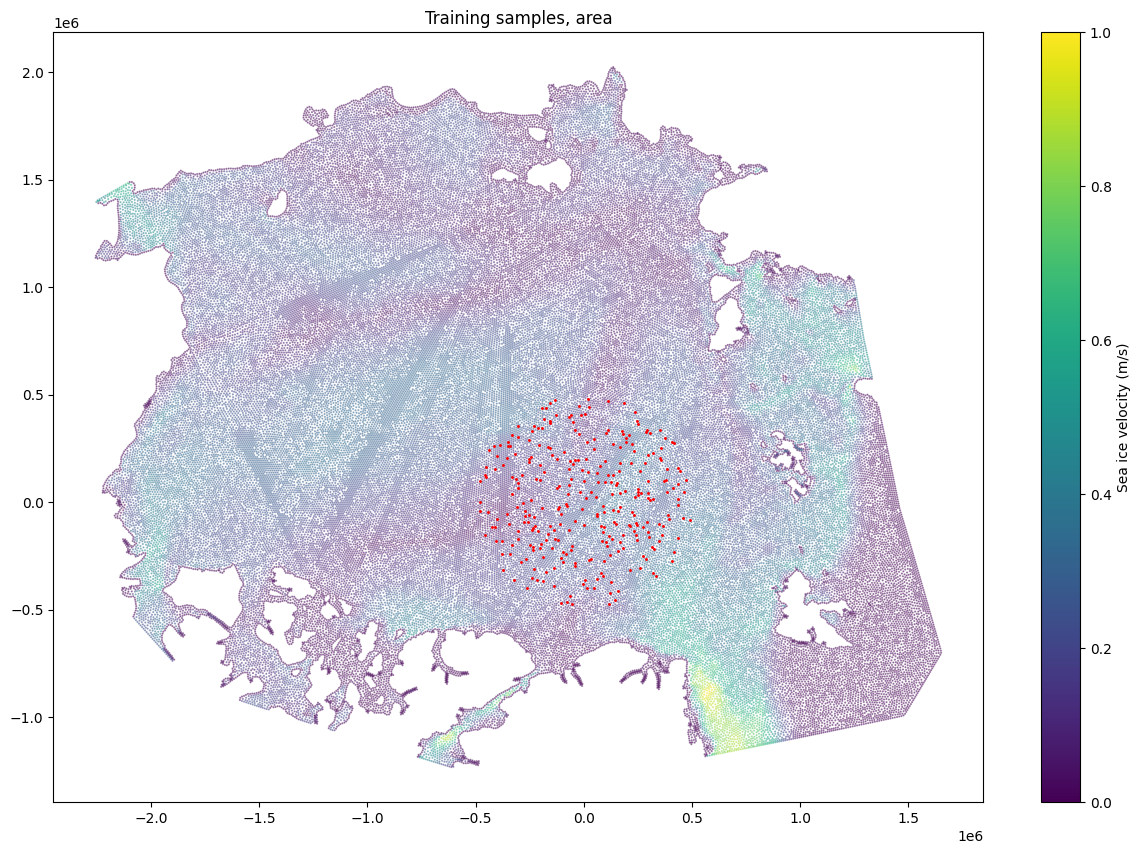

In [2]:
#Load the files (Note, you need to clone the repo first -- upper cells)
file_graphs = [dict(np.load(f'../example_data/{file}')) for file in sorted(os.listdir('../example_data')) if file[-3:]=='npz']
nextsim = Ice_graph(
    file_graphs,
    vertex_element_features =
        ['M_wind_x',
        'M_wind_y',
        'M_ocean_x',
        'M_ocean_y',
        'M_VT_x',
        'M_VT_y',
        'x',
        'y']
)

n_generations = 300
predict_vel = True

radius = 500000 #meters
iterations = 1
time_index = 3 #index of element graph to fetch samples from
time_index_val = 20

samples_train = nextsim.get_samples_area((0,0),radius,time_index=time_index,n_samples=n_generations,elements=False)
samples_val = nextsim.get_samples_area((0,0),radius,time_index=time_index_val,n_samples=int(n_generations/5),elements=False)



selected_graph = nextsim.get_item(time_index,elements=False) 
#samples_train_idx = np.where(samples_train in selected_graph['i'])[0]
samples_train_idx = np.where(np.isin(selected_graph['i'],samples_train))[0]
print(f"Samples train: {samples_train.shape}")
#plot area defined by radius
plt.figure(figsize=(15,10))
vel_norm = np.sqrt(selected_graph['M_VT_x']**2 + selected_graph['M_VT_y']**2)
plt.scatter(selected_graph['x'],selected_graph['y'],c=vel_norm, s= 3 ,marker='.',linewidths=.7,alpha=.4)
plt.title("Training samples, area")
plt.scatter(selected_graph['x'][samples_train_idx],selected_graph['y'][samples_train_idx], color='red',s= 7 ,marker='.',linewidths=.7)
plt.colorbar(label='Sea ice velocity (m/s)')


In [3]:
import importlib
%load_ext autoreload
%autoreload 2


train_graph_list = []
fet = ['Damage', 'Concentration', 'Thickness', 'M_wind_x', 'M_wind_y', 'M_ocean_x', 'M_ocean_y', 'x', 'y']

train_graph_list = nextsim.get_samples_graph(
    (0,0),
    radius,
    [time_index,time_index+2,time_index+4,time_index+6,time_index+8,time_index+10,time_index+12,time_index+14,time_index+16],
    n_samples=n_generations,
    target_iter=iterations,
    e_features=fet,
    include_vertex=True,
    pred_velocity=predict_vel

)
val_graph_list = nextsim.get_samples_graph(
    (0,0),
    radius,
    [time_index_val,time_index_val+2,time_index_val+4],
    n_samples=int(n_generations/5),
    target_iter=iterations,
    e_features=fet,
    include_vertex=True,
    pred_velocity=predict_vel

)



Generating samples at time 3:   0%|          | 0/300 [00:00<?, ?it/s]

Generating samples at time 24: 100%|██████████| 60/60 [00:00<00:00, 1011.59it/s]


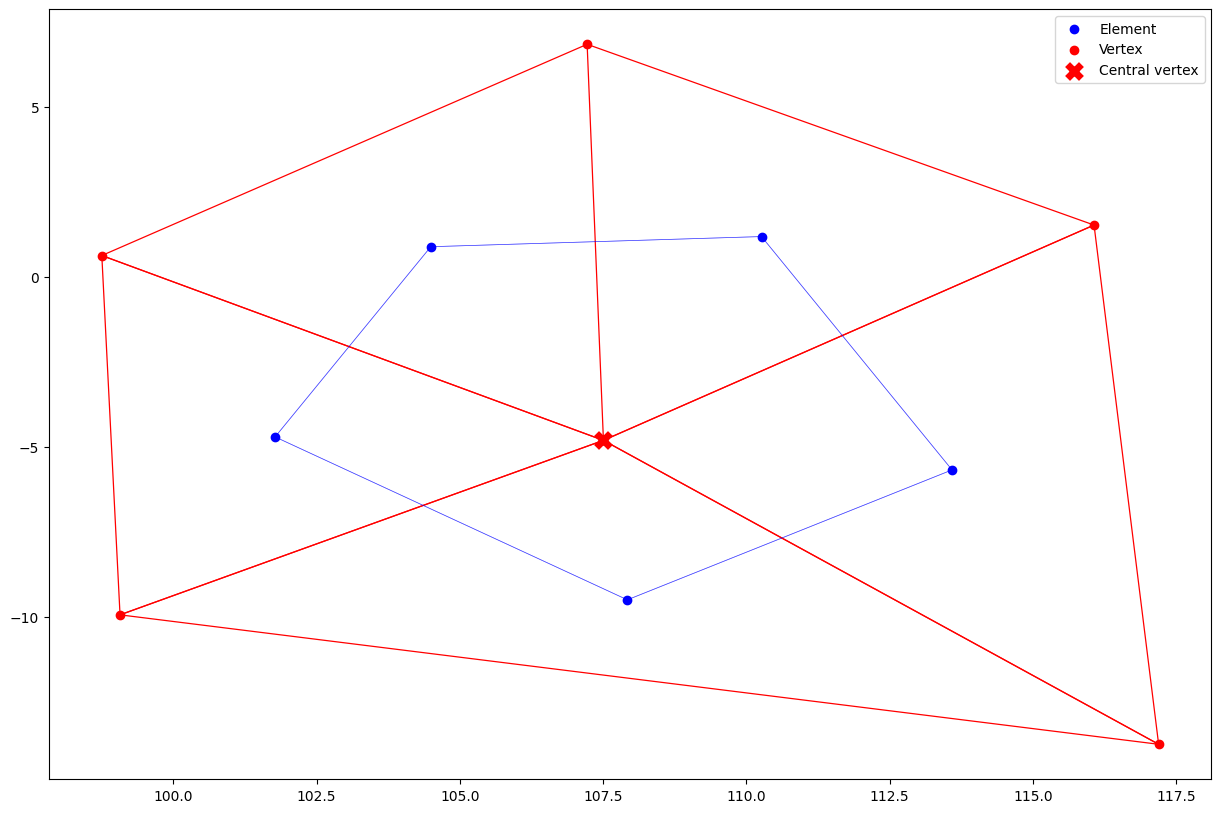

In [4]:
e_g,v_g = train_graph_list[0]

plt.figure(figsize=(15,10))
central_pos = v_g.y[1]


for edge in v_g.edge_index.t():
    positions = np.array([v_g.pos.t()[edge[0]],v_g.pos.t()[edge[1]]])
    positions = positions.transpose()
    plt.plot(positions[0],positions[1],color='red',linewidth=.9)

for edge in e_g.edge_index.t():
    positions = np.array([e_g.pos.t()[edge[0]],e_g.pos.t()[edge[1]]])
    positions = positions.transpose()
    plt.plot(positions[0],positions[1],color='blue',linewidth=.5,alpha=.5)

plt.scatter(e_g.pos[0],e_g.pos[1],color='blue',label='Element')
plt.scatter(v_g.pos[0],v_g.pos[1],color='red',label='Vertex')

plt.scatter(central_pos[0],central_pos[1],marker='x', s=100, linewidth=5, c='red', label='Central vertex')

plt.legend()

Epoch 1/50
	Average Training Loss: 7.78421609
	Average Validation Loss: 3.02000117
Epoch 6/50
	Average Training Loss: 0.42136795
	Average Validation Loss: 0.52407974
Epoch 11/50
	Average Training Loss: 0.38112112
	Average Validation Loss: 0.48601841
Epoch 16/50
	Average Training Loss: 0.27036080
	Average Validation Loss: 0.25456553
Epoch 21/50
	Average Training Loss: 0.16532099
	Average Validation Loss: 0.16967387
Epoch 26/50
	Average Training Loss: 0.10863034
	Average Validation Loss: 0.12843336
Epoch 31/50
	Average Training Loss: 0.07376368
	Average Validation Loss: 0.11951421
Epoch 36/50
	Average Training Loss: 0.05300712
	Average Validation Loss: 0.04812766
Epoch 41/50
	Average Training Loss: 0.06801675
	Average Validation Loss: 0.06632388
Epoch 46/50
	Average Training Loss: 0.03978544
	Average Validation Loss: 0.06625643


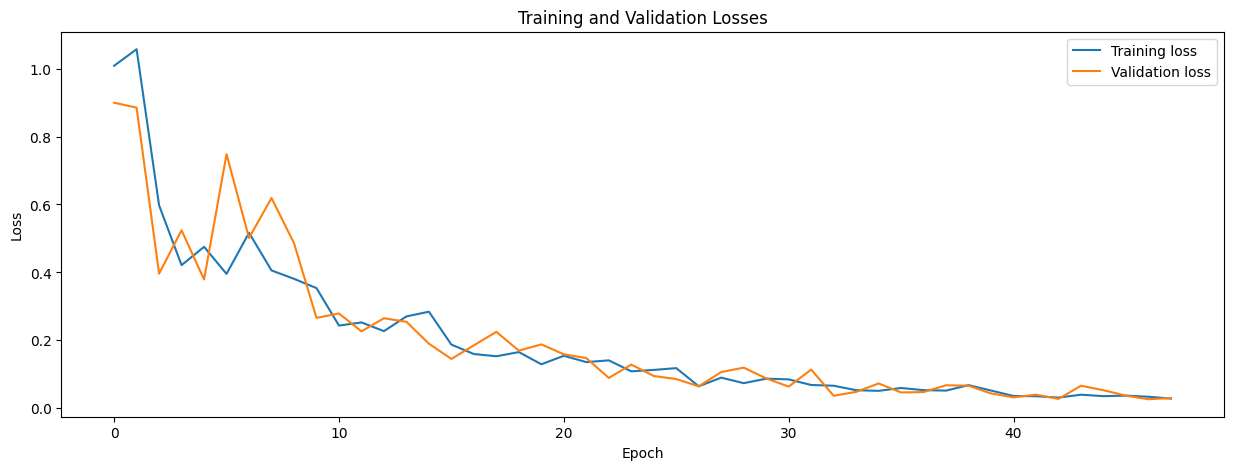

In [5]:
# TRAINING LOOP

#compute norm transform
transform_train = compute_normalization_batch(train_graph_list)
transform_val = compute_normalization_batch(val_graph_list)

#create datasets and loaders
batch_size = 128
train_dataset = Ice_graph_dataset(train_graph_list, transform=None)
val_dataset = Ice_graph_dataset(val_graph_list, transform=None)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

e_graph = next(iter(train_dataset))[0] #just to get the num_features
num_features1 = e_graph.x.shape[-1]  # Node feature dimension

v_graph = next(iter(train_dataset))[1] #just to get the num_features
num_features2 = v_graph.x.shape[-1]  # Node feature dimension

hidden_channels = 12
num_classes = e_graph.y[0].shape[0] # trajectory lenght *2, since we have x,y.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNN_2G(num_features1,num_features2, hidden_channels, num_classes,dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4)
scheduler = ExponentialLR(optimizer, gamma=0.95)
loss = nn.L1Loss()
num_epochs = 50


#trianing loop
training_losses = []
validation_losses = []
for epoch in range(num_epochs):
    training_loss = process_dataloader(model, train_dataloader, device, optimizer, scheduler, loss)
    training_losses.append(training_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"\tAverage Training Loss: {training_loss:.8f}")

    val_loss = process_dataloader(model, val_dataloader, device, criterion=loss)
    validation_losses.append(val_loss)

    if epoch % 5 == 0:
        print(f"\tAverage Validation Loss: {val_loss:.8f}")

    scheduler.step() if scheduler else None


#plot losses curve
plt.figure(figsize=(15,5))
plt.plot(training_losses[2:],label='Training loss')
plt.plot(validation_losses[2:],label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [6]:
#define metrics
mse =  nn.MSELoss(reduction='none')
mae = nn.L1Loss(reduction='none')

lossess = []
targets = []
predictions = []
init_coords = []
for graph in val_dataloader:
        e_g,v_g = graph[0].to(device),graph[1].to(device)
        output = model(e_g,v_g).cpu().detach().squeeze()
        target = e_g.y[0].cpu().detach()
        targets.append(target) #target
        predictions.append(output) #predicted
        init_coords.append(e_g.y[-1])#initial coords

targets = torch.cat(targets)
predictions = torch.cat(predictions)
init_coords = torch.cat(init_coords)*1000

rmse_position,mae_vel_norm,angles,target_vel,predicted_vel = compute_metrics(targets,predictions,init_coords,predict_vel)

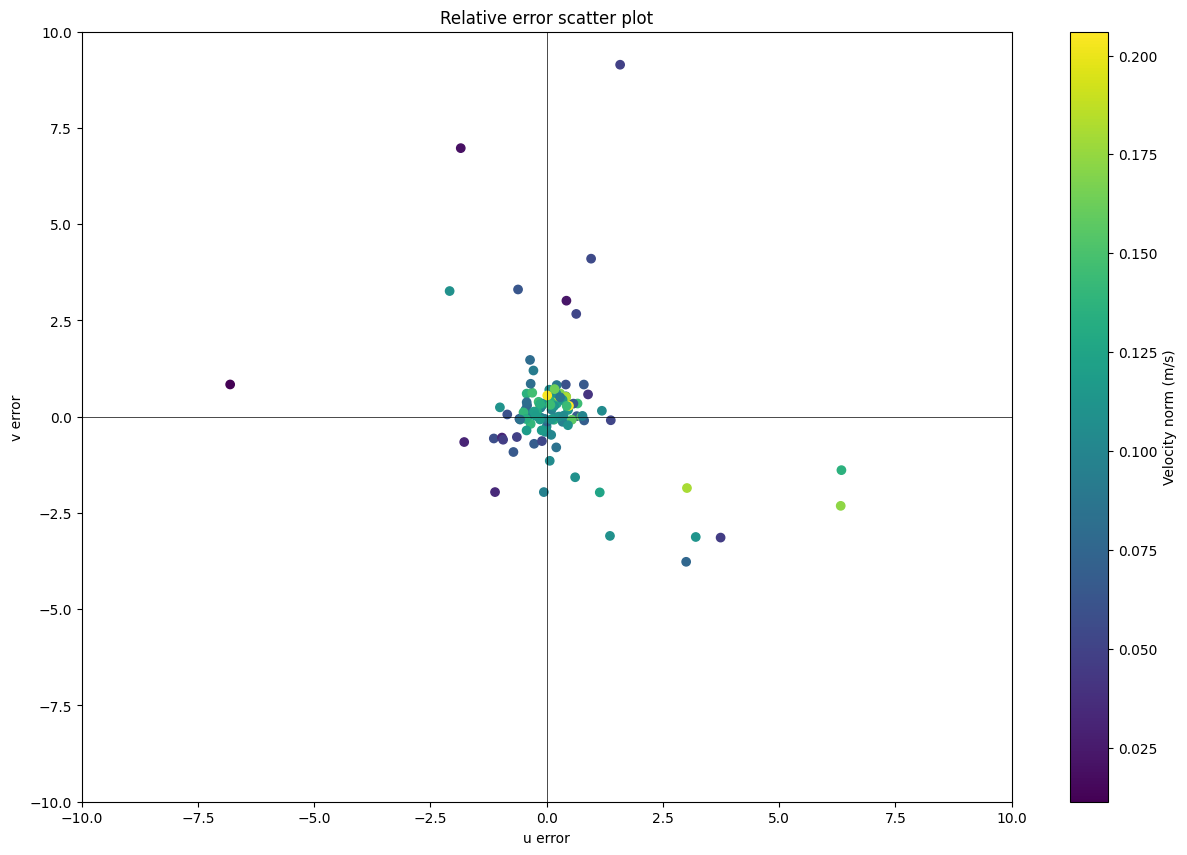

In [9]:
target_vel = target_vel.squeeze()
predicted_vel = predicted_vel.squeeze()

#get relative errors
u_error = (target_vel[0,:] - predicted_vel[0,:])/target_vel[1,:] #relative error
v_error = (target_vel[1,:] - predicted_vel[1,:])/target_vel[1,:]

#compute target velocitity norm
target_vel_norm = velocity_norm(target_vel)


#plot error scatter
plt.figure(figsize=(15,10))
plt.scatter(u_error,v_error, c=target_vel_norm)
#center at 00 
plt.axhline(0, color='black',linewidth=.5)
plt.axvline(0, color='black',linewidth=.5)
zoom = 10
plt.xlim(-zoom,zoom)
plt.ylim(-zoom,zoom)
plt.colorbar(label='Velocity norm (m/s)')
plt.xlabel('u error')
plt.ylabel('v error')
plt.title('Relative error scatter plot')
plt.show()

RMSE position shape: torch.Size([120, 1]), MAE velocity shape: torch.Size([1, 120]), Angle shape: torch.Size([1, 120])


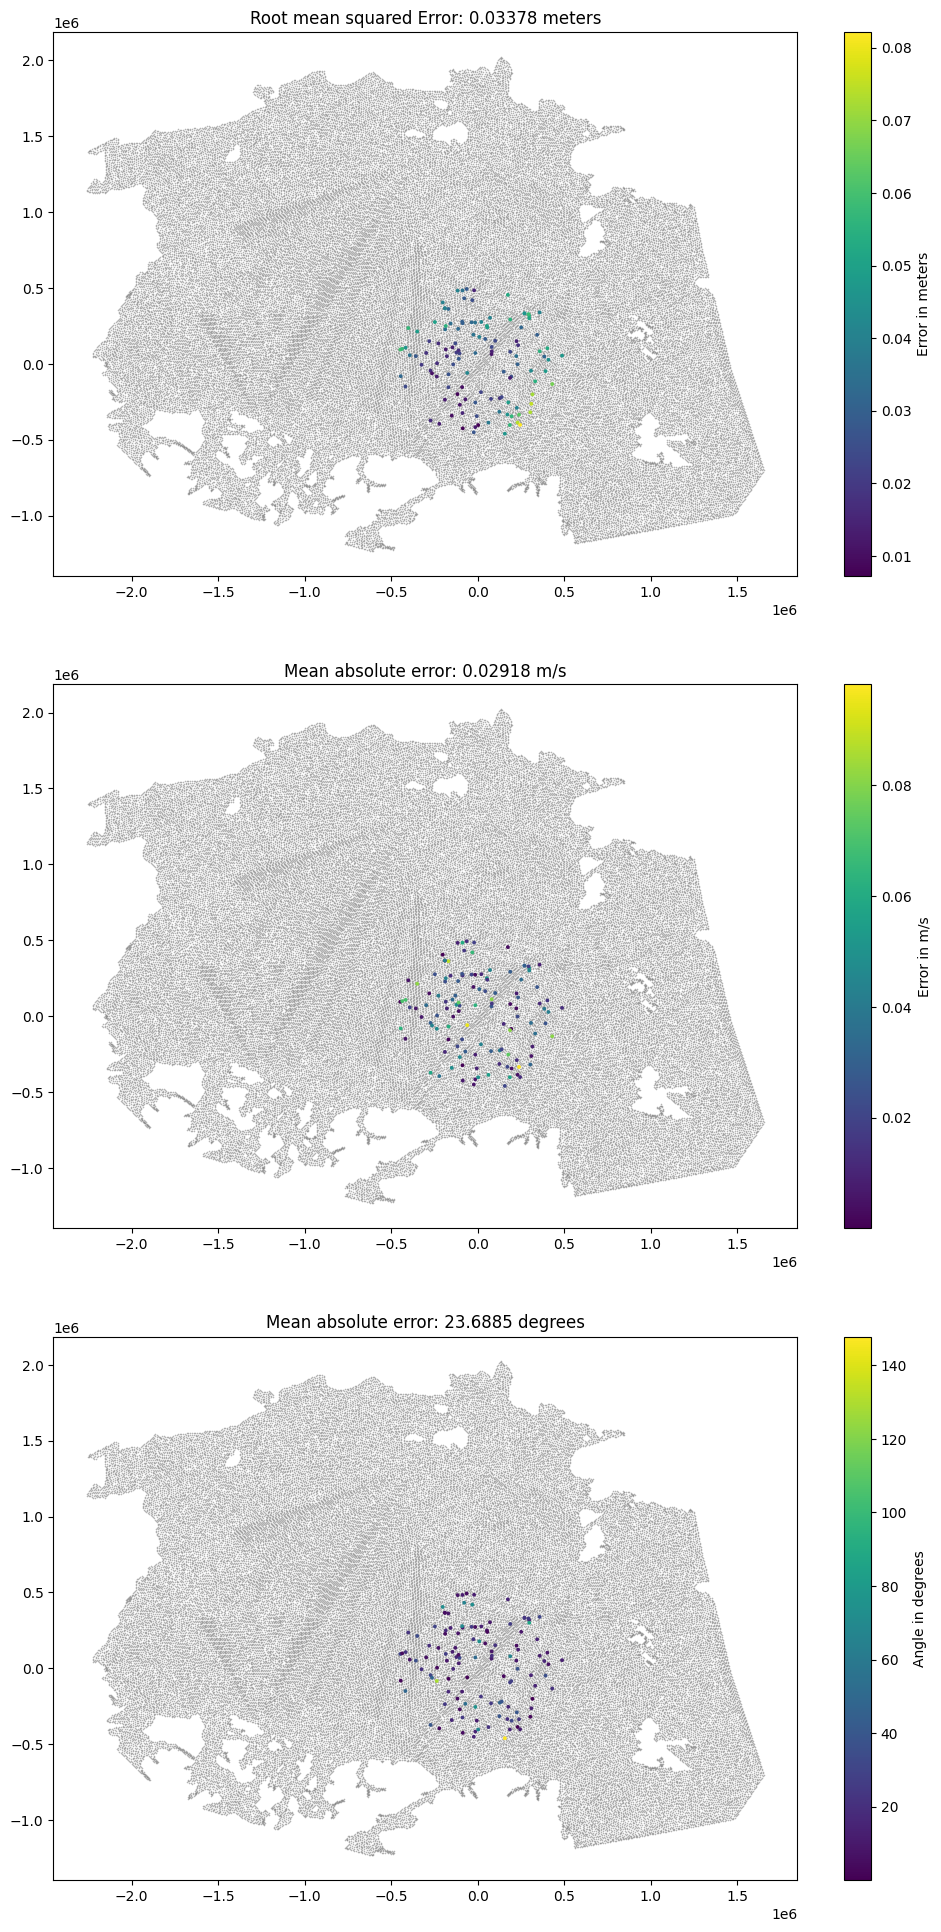

In [10]:
print(f"RMSE position shape: {rmse_position.shape}, MAE velocity shape: {mae_vel_norm.shape}, Angle shape: {angles.shape}")

position_spatial_mean = torch.mean(rmse_position,dim=1)
velocity_spatial_mean = torch.mean(mae_vel_norm,dim=0)
angle_spatial_mean = torch.mean(angles, dim=0)

position_absolute_mean = float(torch.mean(rmse_position))
velocity_absolute_mean = float(torch.mean(mae_vel_norm))
angle_absolute_mean = float(torch.mean(angles))

position_std = float(torch.std(rmse_position))
velocity_std = float(torch.std(mae_vel_norm))
angle_std = float(torch.std(angles))


fig, axs = plt.subplots(3,1,figsize=(12,24))

#position
axs[0].scatter(selected_graph['x'],selected_graph['y'],c='grey', s= 1 ,marker='.',linewidths=.7,alpha=.5)
im = axs[0].scatter(init_coords[:,0],init_coords[:,1],c=np.clip(position_spatial_mean,0,position_absolute_mean+5*position_std),s=3, cmap='viridis')
#axs[0].set_xlim([-0.8e6, 0.8e6])
#axs[0].set_ylim([-0.75e6, 0.75e6])
axs[0].set_title("Root mean squared Error: "+str(position_absolute_mean)[:7]+" meters")
plt.colorbar( im, label="Error in meters")

#velocity
im = axs[1].scatter(selected_graph['x'],selected_graph['y'],c='grey', s= 1 ,marker='.',linewidths=.7,alpha=.5)
im = axs[1].scatter(init_coords[:,0],init_coords[:,1],c=np.clip(velocity_spatial_mean,0,velocity_absolute_mean+5*velocity_std),s=3, cmap='viridis')
#axs[1].set_xlim([-0.8e6, 0.8e6])
#axs[1].set_ylim([-0.75e6, 0.75e6])
axs[1].set_title("Mean absolute error: "+str(velocity_absolute_mean)[:7]+" m/s")
plt.colorbar( im, label="Error in m/s")

#angle
im = axs[2].scatter(selected_graph['x'],selected_graph['y'],c='grey', s= 1 ,marker='.',linewidths=.7,alpha=.5)
im = axs[2].scatter(init_coords[:,0],init_coords[:,1],c=np.clip(angle_spatial_mean,0,angle_absolute_mean+5*angle_std),s=3, cmap='viridis')
#axs[2].set_xlim([-0.8e6, 0.8e6])
#axs[2].set_ylim([-0.75e6, 0.75e6])
axs[2].set_title("Mean absolute error: "+str(angle_absolute_mean)[:7]+" degrees")
plt.colorbar( im, label="Angle in degrees")




Text(0.5, 0, 'Angle degrees)')

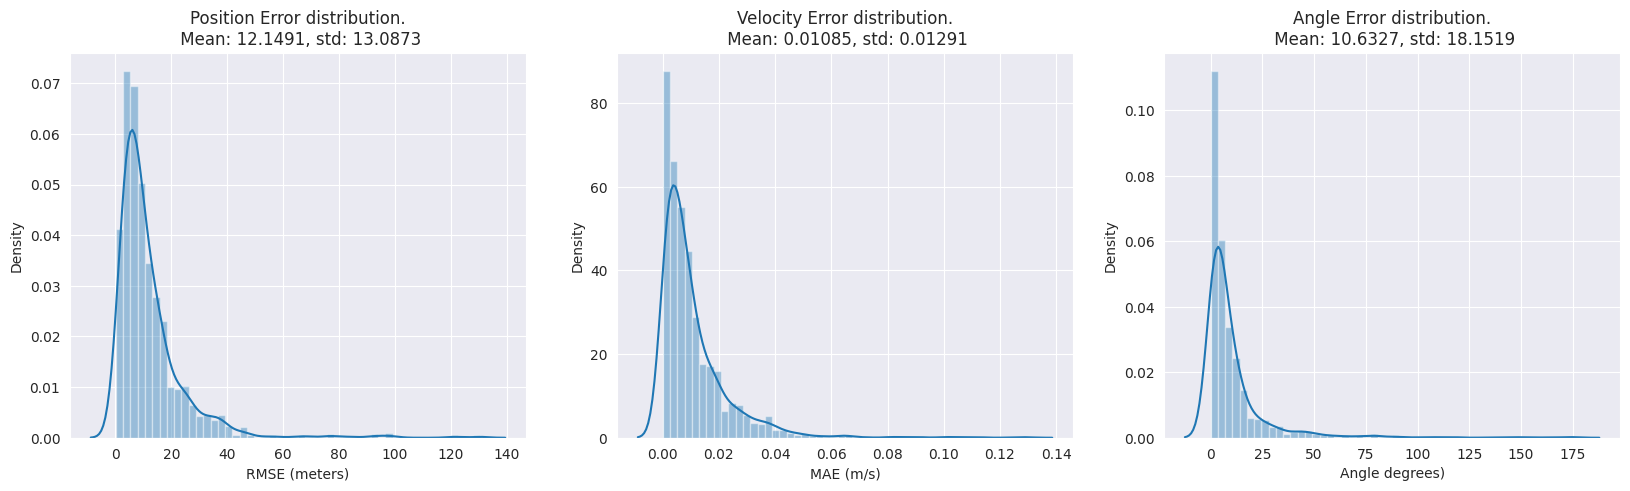

In [203]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#error data distributions
sns.set_style('darkgrid')

fig, axs = plt.subplots(1,3,figsize=(20,5))

sns.distplot(ax=axs[0],a=position_spatial_mean,bins=50)
axs[0].set_title(f"Position Error distribution.\n Mean: {str(position_absolute_mean)[:7]}, std: {str(position_std)[:7]}")
axs[0].set_xlabel("RMSE (meters)")

sns.distplot(ax=axs[1],a=velocity_spatial_mean,bins=50)
axs[1].set_title(f"Velocity Error distribution.\n Mean: {str(velocity_absolute_mean)[:7]}, std: {str(velocity_std)[:7]}")
axs[1].set_xlabel("MAE (m/s)")

sns.distplot(ax=axs[2],a=angle_spatial_mean,bins=50)
axs[2].set_title(f"Angle Error distribution.\n Mean: {str(angle_absolute_mean)[:7]}, std: {str(angle_std)[:7]}")
axs[2].set_xlabel("Angle degrees)")




In [ ]:
transfrom = compute_normalization_batch(train_graph_list)
l = train_graph_list
train_dataset = Ice_graph_dataset(l, transform=None)
train_dataset_nornmalized = Ice_graph_dataset(l, transform=transfrom)

feature = []
for g in train_dataset:
    feature.append(g[1].x[:,1])

feature_normalized = []
for g in train_dataset_nornmalized:
    feature_normalized.append(g[1].x[:,1])

feature_from_list = []

for g in train_graph_list:
    feature_from_list.append(g[1].x[:,1])

feature = np.concatenate(feature)
feature_normalized = np.concatenate(feature_normalized)
feature_from_list = np.concatenate(feature_from_list)

fig,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].hist(feature,bins=100)
axs[0].set_title('Original feature')
axs[1].hist(feature_normalized,bins=100)
axs[1].set_title('Normalized feature')
axs[2].hist(feature_from_list,bins=100)
axs[2].set_title("feature from list")

In [ ]:
## TIMMINGS...
import time

times = {
    "neighbours":[],
    "trajectories":[],
    "e_node_features":[],
    "e_edge_index":[],
    "e_edge_distances":[],
    "v_node_features":[],
    "v_edge_index":[],
    "v_edge_distances":[],
}

total_time = time.time()


target_iter:int = 1
e_features: list[str] = ['Damage', 'Concentration', 'Thickness', 'M_wind_x', 'M_wind_y', 'M_ocean_x', 'M_ocean_y', 'x', 'y']
v_features: list[str] = ['M_wind_x', 'M_wind_y', 'M_ocean_x', 'M_ocean_y', 'x', 'y']
include_vertex:bool = True

for sample in tqdm(samples_train):

    vertex_i= sample

    element_data = nextsim.get_item(time_index,elements=True)
    vertex_data = nextsim.get_item(time_index,elements=False)
    vertex_index= np.where(vertex_data['i']==vertex_i)[0]

    #get the neighbours

    t_neighbours = time.time()
    e_neighbours,v_neighbours = nextsim.compute_vertex_neighbourhood(vertex_index=vertex_index,time_index=time_index,return_vertex=include_vertex)
    times["neighbours"].append(time.time()-t_neighbours)

    t_trajectories = time.time()
    #get target coordinates
    target = nextsim.get_vertex_trajectories(time_index,vertex_i=vertex_i,iter=target_iter+1)

    if len(target.shape)==1 or target.shape[0] != target_iter+1:
        print("miss")    #skip vertexs / elements that disapear
    target = target.flatten().to(torch.float32)/1000 #tokm

    #store initial coordinates for visulisazion
    vertex_idx = vertex_index
    x_center = vertex_data['x'][vertex_idx]
    y_center = vertex_data['y'][vertex_idx]
    element_coords = np.array([x_center,y_center])/1000 #tokm
    y = [target,element_coords]
    times["trajectories"].append(time.time()-t_trajectories)


    t_e_node_features = time.time()
    #get node features
    node_features, features_indeces = nextsim._Ice_graph__get_node_features(element_data,e_features,e_neighbours)
    times["e_node_features"].append(time.time()-t_e_node_features)

    t_e_edge_features = time.time()
    #get edge features
    edge_index = nextsim._Ice_graph__get_element_edge_index(element_data,e_neighbours,edge_conectivity=True)
    times["e_edge_index"].append(time.time()-t_e_edge_features)

    t_e_edge_distances = time.time()
    #get edge distances and node positions
    edge_dist,positions = nextsim._Ice_graph__compute_edge_distances(feature_indeces=features_indeces,node_features=node_features,edge_index=edge_index)
    times["e_edge_distances"].append(time.time()-t_e_edge_distances)
    #Now we can create our torch-geometric graph using the "Data" class
    e_graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_dist,pos=positions, y=y)
    v_graph = None

    if include_vertex:
        t_v_node_features = time.time()
        #get node features
        node_features, features_indeces = nextsim._Ice_graph__get_node_features(vertex_data,v_features,v_neighbours)
        times["v_node_features"].append(time.time()-t_v_node_features)

        t_v_edge_features = time.time()
        #get edge features
        edge_index = nextsim._Ice_graph__get_vertex_edge_index(vertex_neighbours=v_neighbours,triangles=element_data['t'][e_neighbours])
        times["v_edge_index"].append(time.time()-t_v_edge_features)

        t_v_edge_distances = time.time()
        #get edge distances and node positions
        edge_dist,positions = nextsim._Ice_graph__compute_edge_distances(feature_indeces=features_indeces,node_features=node_features,edge_index=edge_index)
        times["v_edge_distances"].append(time.time()-t_v_edge_distances)

        #Now we can create our torch-geometric graph using the "Data" class
        v_graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_dist,pos=positions, y=y)

    v_g = v_graph
    e_g = e_graph

total_time = time.time()-total_time

print("Total time: ",total_time)
print(f"Neighbours time {100*np.sum(times['neighbours'])/total_time:.4f} %")
print(f"Trajectories time {100*np.sum(times['trajectories'])/total_time:.4f} %")
print(f"Element node features time {100*np.sum(times['e_node_features'])/total_time:.4f} %")
print(f"Element edge features time {100*np.sum(times['e_edge_index'])/total_time:.4f} %")
print(f"Element edge distances time {100*np.sum(times['e_edge_distances'])/total_time:.4f} %")
print(f"Vertex node features time {100*np.sum(times['v_node_features'])/total_time:.4f} %")
print(f"Vertex edge features time {100*np.sum(times['v_edge_index'])/total_time:.4f} %")
print(f"Vertex edge distances time {100*np.sum(times['v_edge_distances'])/total_time:.4f} %")


#plot time distribution as a pie chart
plt.figure(figsize=(10,10))
plt.pie([np.sum(times[key]) for key in times.keys()],labels=times.keys(),autopct='%1.1f%%')
plt.title(f"Time distribution for element graph creation \n Total time: {total_time:.2f}s, n_samples: {len(samples_train)}")
plt.show()

